In [1]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import pytorch_lightning as pl
from torch.nn import functional as F
import torch as torch
import matplotlib.pyplot as plt
import torch.nn as nn
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [2]:
class WeatherDataset(Dataset):
    def __init__(self, path, input_columns, input_width, label_column, label_width):
        df = pd.read_csv(path)
                
        self.input_width = input_width
        self.label_width = label_width
        
        self.input_columns = input_columns
        self.label_column = label_column

            
        end_index = len(df)
        start_index = 0
        sequence_length = input_width+label_width
        num_seqs = end_index - start_index - sequence_length + 1
        self.start_positions = np.arange(0, num_seqs, 1)
        
        self.input_data = torch.tensor(df[self.input_columns].to_numpy(), dtype=torch.float32)
        self.label_data = torch.tensor(df[self.label_column].to_numpy(), dtype=torch.float32)
        
    def __len__(self):
        return len(self.start_positions)

    def __getitem__(self, idx):
        input_start = self.start_positions[idx]
        input_end = input_start + self.input_width
        
        label_start = input_end
        label_end = label_start + self.label_width
        return {'input':self.input_data[input_start:input_end,:],
                'label':self.label_data[label_start:label_end]}

In [3]:
feature_columns = ['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)',
        'Wx', 'Wy', 'max Wx', 'max Wy', 'Day sin', 'Day cos',
       'Year sin', 'Year cos']

In [45]:
input_width=3
label_width=1

In [46]:
test_dataset = WeatherDataset('test.csv',feature_columns,input_width,'T (degC)',label_width)
train_dataset = WeatherDataset('train.csv',feature_columns,input_width,'T (degC)',label_width)
val_dataset = WeatherDataset('val.csv',feature_columns,input_width,'T (degC)',label_width)

In [47]:
test_dataloader = DataLoader(test_dataset,batch_size=32,num_workers=6)
val_dataloader = DataLoader(val_dataset,batch_size=32,num_workers=6)
train_dataloader = DataLoader(train_dataset,batch_size=32,num_workers=6, shuffle=True)

In [50]:
class Linear(pl.LightningModule):
    
    def __init__(self, input_width, num_features, label_width):
        super().__init__()

        self.train_mae = pl.metrics.MeanAbsoluteError()
        self.valid_mae = pl.metrics.MeanAbsoluteError()
        self.test_mae = pl.metrics.MeanAbsoluteError()

        self.layers = nn.Sequential(nn.Conv1d(in_channels=19, out_channels=32,kernel_size=3),
                                    nn.Flatten(),
                                    nn.ReLU(inplace=True),
                                    nn.Linear(32,32),
                                    nn.ReLU(inplace=True),
                                    nn.Linear(32,1),            
                                   )
        
    def forward(self,x):
        return self.layers(x.permute(0,2,1))
    
    def training_step(self, batch, batch_idx):
        x = batch['input']
        y = batch['label']
        yhat = self(x)
        loss = F.mse_loss(yhat, y)
        self.train_mae(yhat, y)
        self.log('train_loss', loss, 'train_mae', self.train_mae)
        self.log('train_mae', self.train_mae) 
        return loss

    def validation_step(self, batch, batch_idx):
        x = batch['input']
        y = batch['label']
        yhat = self(x)
        loss = F.mse_loss(yhat, y)
        self.valid_mae(yhat, y)
        self.log('val_loss', loss)
        self.log('val_mae', self.valid_mae) 
    
    
    def test_step(self, batch, batch_idx):
        x = batch['input']
        y = batch['label']
        yhat = self(x)
        loss = F.mse_loss(yhat, y)
        self.test_mae(yhat, y)
        self.log('test_loss', loss)
        self.log('test_mae', self.test_mae) 
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        return optimizer

In [51]:
model = Linear(input_width, len(feature_columns), label_width)

In [52]:
trainer = pl.Trainer(gpus=0, 
                     progress_bar_refresh_rate=20,
                     max_epochs=20,
                     callbacks=[EarlyStopping(monitor='val_loss',patience=3,mode='min')])   

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


In [53]:
trainer.fit(model, train_dataloader, val_dataloader)


  | Name      | Type              | Params
------------------------------------------------
0 | train_mae | MeanAbsoluteError | 0     
1 | valid_mae | MeanAbsoluteError | 0     
2 | test_mae  | MeanAbsoluteError | 0     
3 | layers    | Sequential        | 2.9 K 
------------------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params


1

In [54]:
trainer.test(model,test_dataloader);


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(0.0060),
 'test_mae': tensor(0.0545),
 'val_loss': tensor(0.0060),
 'val_mae': tensor(0.0537)}
--------------------------------------------------------------------------------


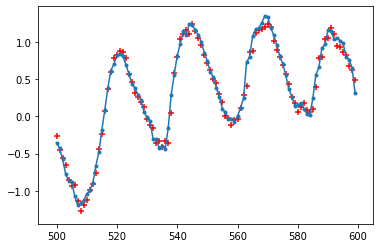

In [59]:
labels = []
predictions = []
model.eval()
for batch in test_dataloader:
    x = batch['input']
    y = batch['label']
    with torch.no_grad():
        yhat = model(x)
    predictions.append(yhat)
    labels.append(y)
    
predictions = torch.cat(predictions)
labels = torch.cat(labels)

start=500
end=600
xaxis=np.arange(start,end)
fig, ax = plt.subplots()
ax.plot(xaxis,labels[start:end],marker='.')
ax.scatter(xaxis,predictions[start:end],color='r',marker='+')